In [1]:
import lrr_prototype as lrr

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
base_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought'
data_dir = f'{base_dir}/data'
reservoir_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/DROM_CONUS_Analysis/Data/HydroShare'
output_dir = f'{data_dir}/results/lrr_output'

os.chdir(base_dir)

In [115]:
# ---- Prepare the model run for a specific basin ---- #

huc4 = '1203'

# constant parameters
grid_length = 111 / 8    # grid length (km)

# simulation period
start_date = '2005-10-01'
end_date = '2018-10-01'

# define run directory
run_dir = f'/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/results/lrr_output/{huc4}'
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

# read conus grid nc
conus_grid_nc_path = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/conus_nldas_grid.nc'
lat_array_conus, lon_array_conus, grid_id_array_conus, flow_dir_array_conus = lrr.read_conus_grid_nc(conus_grid_nc_path)

# read conus reservoir nc
conus_res_nc_path = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/reservoirs.nc'
res_gid_array, res_grid_id_array, res_max_storage_array, res_lat_array, res_lon_array = lrr.read_conus_reservoir_nc(conus_res_nc_path)

# read huc4 basin
nhd_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Drought_Cycle_Analysis/Data'
gdf_huc2_conus, gdf_huc4_conus, gdf_huc4 = lrr.read_huc4_basin(huc4, nhd_data_dir)

# get grids in huc4
gdf_huc4_points, lon_index_array, lat_index_array = lrr.get_grids_in_hu(lon_array_conus, lat_array_conus, gdf_huc4)

# sort grids by flow direction
upstream_grid_dict, upstream_grid_id_dict, G, flow_dir_array_huc4 = lrr.sort_grids_by_flow_dir(flow_dir_array_conus, gdf_huc4_points, grid_id_array_conus, lat_array_conus, lon_array_conus)

# read nldas runoff
nldas_runoff_nc_path = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/nldas_runoff.nc'
nldas_qs_array, nldas_qsb_array = lrr.read_nldas_runoff(nldas_runoff_nc_path, lat_index_array, lon_index_array, start_date, end_date)    # [time, lat, lon]

# read pdsi
pdsi_file_path = f'/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/pdsi_{huc4}.csv'
pdsi_array = lrr.read_pdsi(pdsi_file_path, start_date, end_date)

# prepare doy array
doy_array = pd.date_range(start_date, end_date).dayofyear.values

# save variables
# save_var_list = [
#     'grid_id', 'reservoir_id', 'reservoir_storage_start', 'reservoir_storage_end', 'outflow_before_operation', 'outflow_after_operation', 
#     'grid_storage_start', 'grid_storage_end', 'flow_direction']
save_var_list = []    # don't save any variables, just for analysis

In [119]:
# ---- Calculate model metric for each run ---- #

def calculate_run_metric(
        model_states: list,    # model states
        start_date: str,    # start date of the simulation
        end_date: str,    # end date of the simulation
        start_date_calibration: str,    # start date of the calibration period
        end_date_calibration: str,    # end date of the calibration period
    ):
    """
    Calculate model metric for each run.
        The metric is based on the reservoir release.
    
    Return:
        metric_list: [[reservoir_id, r2_release, pbias_release, nrmse_release], [...], ...]
        df_reservoir_ts: dataframe of reservoir time series
    """

    date_list = pd.date_range(start_date, end_date, freq='D').strftime("%Y-%m-%d").tolist()
    # check if the date list is the same as the model states
    if len(date_list) != len(model_states):
        raise ValueError('The length of the date list is not the same as the model states.')

    # Access the first model state to get grid attributes
    grid_id = model_states[0]['grid_id'][:, :].astype(int)
    flow_dir_grid = model_states[0]['flow_direction'][:, :].astype(int)
    reservoir_id_grid = model_states[0]['reservoir_id'][:, :].astype(int)

    reservoir_in_huc4_id = np.unique(reservoir_id_grid[(flow_dir_grid!=-1) & (reservoir_id_grid!=0)])    # get the reservoir id in the huc4 basin
    # Create dictionary to store reservoir time series
    reservoir_ts_dict = {'date': pd.to_datetime(date_list)}
    for reservoir_id in reservoir_in_huc4_id:
        reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_start'] = np.zeros(len(date_list))
        reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_end'] = np.zeros(len(date_list))
        reservoir_ts_dict[f'reservoir_{reservoir_id}_inflow'] = np.zeros(len(date_list))
        reservoir_ts_dict[f'reservoir_{reservoir_id}_release'] = np.zeros(len(date_list))

    # Loop through each model state
    for i, date in enumerate(date_list):
        ds = model_states[i]
        reservoir_storage_start_grid = ds['reservoir_storage_start'][:, :]
        reservoir_storage_end_grid = ds['reservoir_storage_end'][:, :]
        outflow_before_operation_grid = ds['outflow_before_operation'][:, :]
        outflow_after_operation_grid = ds['outflow_after_operation'][:, :]

        for reservoir_id in reservoir_in_huc4_id:
            reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_start'][i] = reservoir_storage_start_grid[reservoir_id_grid==reservoir_id]
            reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_end'][i] = reservoir_storage_end_grid[reservoir_id_grid==reservoir_id]

            grid_id_associated = grid_id[reservoir_id_grid==reservoir_id][0]    # get the grid id associated with the reservoir
            inflow = outflow_before_operation_grid[grid_id==grid_id_associated][0]    # get the inflow from the grid: outflow_before_operation
            release = outflow_after_operation_grid[grid_id==grid_id_associated][0]    # get the release from the grid: outflow_after_operation
            reservoir_ts_dict[f'reservoir_{reservoir_id}_inflow'][i] = inflow * 3600 * 24 * 0.000810714    # convert from m3/s to acft/day
            reservoir_ts_dict[f'reservoir_{reservoir_id}_release'][i] = release * 3600 * 24 * 0.000810714    # convert from m3/s to acft/day

    # Convert dictionary to dataframe
    df_reservoir_ts = pd.DataFrame(reservoir_ts_dict)
    df_reservoir_ts.set_index('date', inplace=True)

    # Read reservoir metadata
    df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx')

    # Calculate metrics & store
    metric_list = []    # [[reservoir_id, r2_release, pbias_release, nrmse_release], [...], ...]
    # Read observed release & add to df_reservoir_ts
    for reservoir_id in reservoir_in_huc4_id:
        df_reservoir_ts[f'reservoir_{reservoir_id}_observed_release'] = np.nan
        df_reservoir_ts[f'reservoir_{reservoir_id}_observed_storage_start'] = np.nan
        df_reservoir_ts[f'reservoir_{reservoir_id}_observed_inflow'] = np.nan

        reservoir_smax = df_res_meta.loc[df_res_meta['ID']==reservoir_id, 'Maximum Storage'].values[0]
        df_ts = pd.read_csv(f'{reservoir_data_dir}/data_training/{reservoir_id}.csv')
        df_ts[['Storage', 'NetInflow', 'Release']] = df_ts[['Storage', 'NetInflow', 'Release']] * reservoir_smax
        df_ts['Time'] = pd.to_datetime(df_ts['Time'])
        df_ts.set_index('Time', inplace=True)
        # # check if the start date and end date are in the df_ts
        # # if not, skip the reservoir
        # if start_date not in df_ts.index:
        #     print(f'The start date {start_date_calibration} is not in the df_ts of reservoir {reservoir_id}.')
        #     continue
        # if end_date not in df_ts.index:
        #     print(f'The end date {end_date_calibration} is not in the df_ts of reservoir {reservoir_id}.')
        #     continue

        # add observed release to df_reservoir_ts
        df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_release'] = df_ts['Release']
        df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_storage_start'] = df_ts['Storage']
        df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_inflow'] = df_ts['NetInflow']

        # Calculate metrics
        # drop nan
        df_reservoir_ts_dropna = df_reservoir_ts.dropna()

        # access the calibration period
        df_reservoir_ts_dropna = df_reservoir_ts_dropna.loc[start_date_calibration:end_date_calibration]

        # 1. r2 score
        r2_release = r2_score(df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'], df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'])

        # 2. percent bias
        pbias_release = (df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'].sum() - df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].sum()) / df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].sum() * 100

        # 3. nRMSE
        nrmse_release = mean_squared_error(df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'], df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'], squared=False) / df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].mean()
        
        # add to metric list
        metric_list.append([reservoir_id, r2_release, pbias_release, nrmse_release])

    return metric_list, df_reservoir_ts

# # Test
# start_date = '2001-10-01'
# end_date = '2002-10-01'
# start_date_calibration = '2002-01-01'
# end_date_calibration = '2002-10-01'
# metric_list, df_reservoir_ts = calculate_run_metric(model_states, start_date, end_date, start_date_calibration, end_date_calibration)

In [120]:
# ---- Run the model for each grid in the basin ---- #
# ---- Modify the parameters here ---- #

# define range of u_e to test
u_e_array = np.arange(0.05, 1.0, 0.05)

# define the calibration period
start_date_calibration = (pd.to_datetime(start_date) + pd.DateOffset(years=3)).strftime('%Y-%m-%d')    # start date of the calibration period (3 years after the start date), the first 2 years are used for warm up
end_date_calibration = end_date

# initiliaze metric dictionary for all runs
metric_list_all_runs = []    # [[metric_list_run_1], [metric_list_run_2], ...]
df_reservoir_ts_all_runs = []    # [df_reservoir_ts_run_1, df_reservoir_ts_run_2, ...]

# run the model for each u_e
for u_e in u_e_array:
    print(f'Running u_e = {u_e} ...')

    # initialize grid
    nrows, ncols = flow_dir_array_huc4.shape
    grid_id_array_huc4 = grid_id_array_conus[np.ix_(lat_index_array, lon_index_array)]
    grid = lrr.initialize_grid(nrows, ncols, res_grid_id_array, res_gid_array, res_max_storage_array, grid_id_array_huc4, grid_length, flow_dir_array_huc4)

    # run simulation
    model_states = lrr.run_simulation(run_dir, grid_length, upstream_grid_dict, grid, start_date, end_date, nldas_qs_array, nldas_qsb_array, pdsi_array, doy_array, save_var_list, u_e)

    # post-process model states
    metric_list, df_reservoir_ts = calculate_run_metric(model_states, start_date, end_date, start_date_calibration, end_date_calibration)
    metric_list_all_runs.append(metric_list)
    df_reservoir_ts_all_runs.append(df_reservoir_ts)


Running u_e = 0.05 ...
Running u_e = 0.1 ...
Running u_e = 0.15000000000000002 ...
Running u_e = 0.2 ...
Running u_e = 0.25 ...
Running u_e = 0.30000000000000004 ...
Running u_e = 0.35000000000000003 ...
Running u_e = 0.4 ...
Running u_e = 0.45 ...
Running u_e = 0.5 ...
Running u_e = 0.55 ...
Running u_e = 0.6000000000000001 ...
Running u_e = 0.65 ...
Running u_e = 0.7000000000000001 ...
Running u_e = 0.75 ...
Running u_e = 0.8 ...
Running u_e = 0.8500000000000001 ...
Running u_e = 0.9 ...
Running u_e = 0.9500000000000001 ...


In [154]:
metric_list_all_runs[0]

[[1151, -1.5919362723284394, 309.2441734078186, 3.94594335192215],
 [1164, -0.7412104840688694, 156.41130661810416, 2.3973034144728707],
 [1170, -0.1925084719315684, 87.35851615047633, 2.1742579252947003],
 [1171, -1.0816318269672123, 176.9995655554689, 2.455468861785783],
 [1177, -1.959784091900854, 601.7028746702221, 7.3944859509599],
 [1183, -0.4861473367861606, 222.15409386968176, 3.8841974532351826],
 [1188, -7.85461295682442, 790.9783171962652, 8.398214734456223],
 [1194, -2.6232754507481895, 342.8024077099389, 4.028771088195657],
 [1220, -0.8943598022876367, 214.11231065136428, 3.1161383948969528],
 [1237, -0.14077862062472768, 80.38129062631573, 2.288164845642365],
 [1287, -0.027977393922496097, -27.536053675698085, 1.6691288079041233]]

In [3]:

huc4 = '0601'
# start_date = '1998-10-01'
# end_date = '2018-10-01'
start_date = '1980-10-01'
end_date = '2000-10-01'
date_list = pd.date_range(start_date, end_date, freq='D').strftime("%Y-%m-%d").tolist()

# Read the 1st .nc output file to get grid attributes
nc_file_path = f'{output_dir}/{huc4}_model_state_{date_list[0]}.nc'
with nc.Dataset(nc_file_path) as ds:
    grid_id = ds.variables['grid_id'][:, :].astype(int)
    flow_dir_grid = ds.variables['flow_direction'][:, :].astype(int)
    reservoir_id_grid = ds.variables['reservoir_id'][:, :].astype(int)

reservoir_in_huc4_id = np.unique(reservoir_id_grid[(flow_dir_grid!=-1) & (reservoir_id_grid!=0)])    # get the reservoir id in the huc4 basin
# Create dictionary to store reservoir time series
reservoir_ts_dict = {'date': pd.to_datetime(date_list)}
for reservoir_id in reservoir_in_huc4_id:
    reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_start'] = np.zeros(len(date_list))
    reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_end'] = np.zeros(len(date_list))
    reservoir_ts_dict[f'reservoir_{reservoir_id}_inflow'] = np.zeros(len(date_list))
    reservoir_ts_dict[f'reservoir_{reservoir_id}_release'] = np.zeros(len(date_list))

# Read .nc output file
for i, date in enumerate(date_list):
    nc_file_path = f'{output_dir}/{huc4}_model_state_{date}.nc'
    with nc.Dataset(nc_file_path) as ds:
        reservoir_storage_start_grid = ds.variables['reservoir_storage_start'][:, :]
        reservoir_storage_end_grid = ds.variables['reservoir_storage_end'][:, :]
        outflow_before_operation_grid = ds.variables['outflow_before_operation'][:, :]
        outflow_after_operation_grid = ds.variables['outflow_after_operation'][:, :]

        for reservoir_id in reservoir_in_huc4_id:
            reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_start'][i] = reservoir_storage_start_grid[reservoir_id_grid==reservoir_id]
            reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_end'][i] = reservoir_storage_end_grid[reservoir_id_grid==reservoir_id]

            grid_id_associated = grid_id[reservoir_id_grid==reservoir_id][0]    # get the grid id associated with the reservoir
            inflow = outflow_before_operation_grid[grid_id==grid_id_associated][0]    # get the inflow from the grid: outflow_before_operation
            release = outflow_after_operation_grid[grid_id==grid_id_associated][0]    # get the release from the grid: outflow_after_operation
            reservoir_ts_dict[f'reservoir_{reservoir_id}_inflow'][i] = inflow * 3600 * 24 * 0.000810714    # convert from m3/s to acft/day
            reservoir_ts_dict[f'reservoir_{reservoir_id}_release'][i] = release * 3600 * 24 * 0.000810714    # convert from m3/s to acft/day

# Convert dictionary to dataframe
df_reservoir_ts = pd.DataFrame(reservoir_ts_dict)
df_reservoir_ts.set_index('date', inplace=True)

In [ ]:
# ---- Check reservoir water balance: storage change = inflow - release ---- #

plot_start_date = start_date
plot_end_date = end_date
for reservoir_id in reservoir_in_huc4_id:
    df_reservoir_ts[f'reservoir_{reservoir_id}_storage_change_1'] = df_reservoir_ts[f'reservoir_{reservoir_id}_storage_end'] - df_reservoir_ts[f'reservoir_{reservoir_id}_storage_start']
    df_reservoir_ts[f'reservoir_{reservoir_id}_storage_change_2'] = df_reservoir_ts[f'reservoir_{reservoir_id}_inflow'] - df_reservoir_ts[f'reservoir_{reservoir_id}_release']

    fig, ax = plt.subplots()
    df_reservoir_ts.loc[plot_start_date:plot_end_date, f'reservoir_{reservoir_id}_storage_change_1'].plot(ax=ax, label='storage change 1')
    df_reservoir_ts.loc[plot_start_date:plot_end_date, f'reservoir_{reservoir_id}_storage_change_2'].plot(ax=ax, label='storage change 2')
    ax.legend()
    plt.show()

1763
r2 score of release: -0.7491698859699174
pbias of release: 27.36
nrmse of release: 1.048


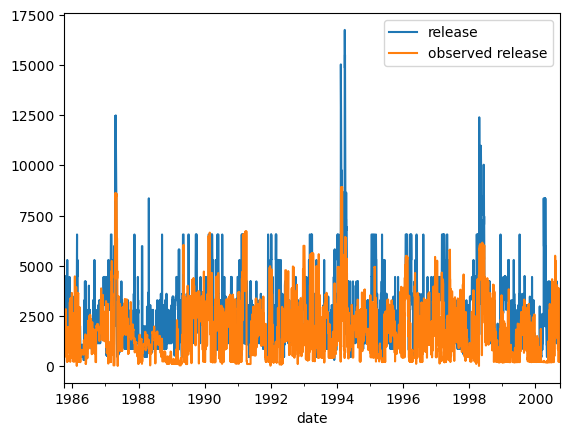

1765
r2 score of release: -1.848147056737047
pbias of release: 53.32
nrmse of release: 1.129


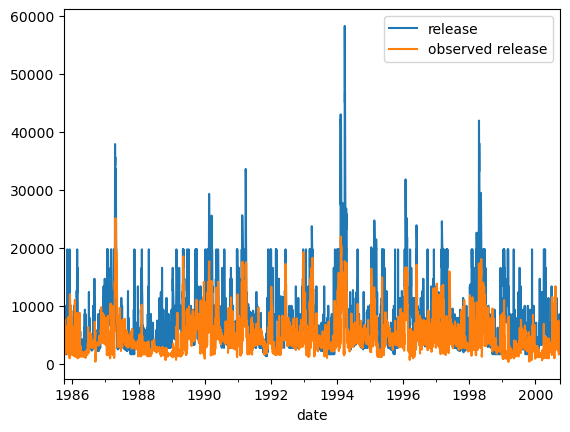

1767
r2 score of release: -1.335110693878668
pbias of release: 54.29
nrmse of release: 1.388


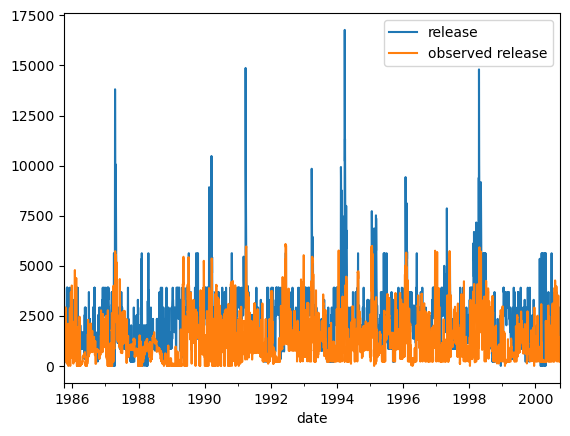

1770
r2 score of release: -1.1494800645654681
pbias of release: 48.33
nrmse of release: 1.207


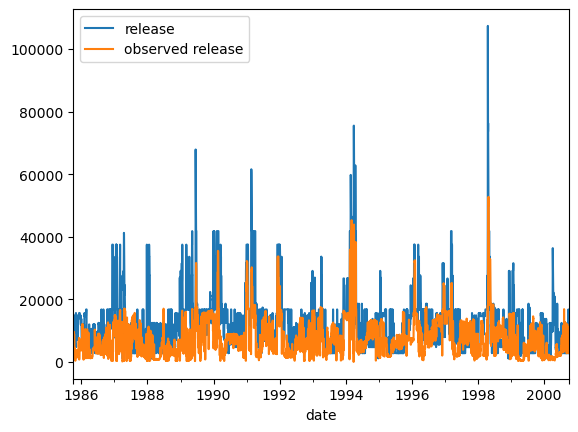

1774
r2 score of release: -2.1557417831434442
pbias of release: 57.38
nrmse of release: 1.470


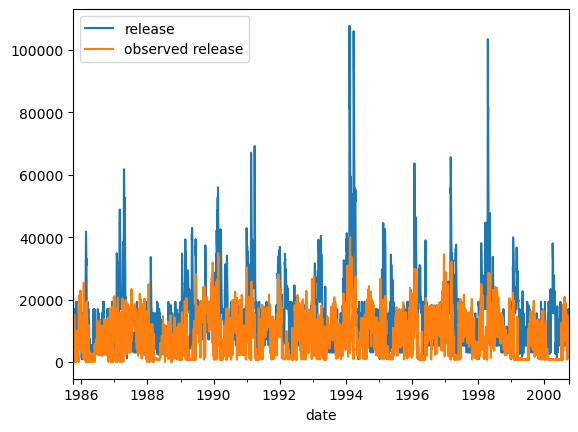

1781
r2 score of release: -3.821257954065816
pbias of release: 79.10
nrmse of release: 1.564


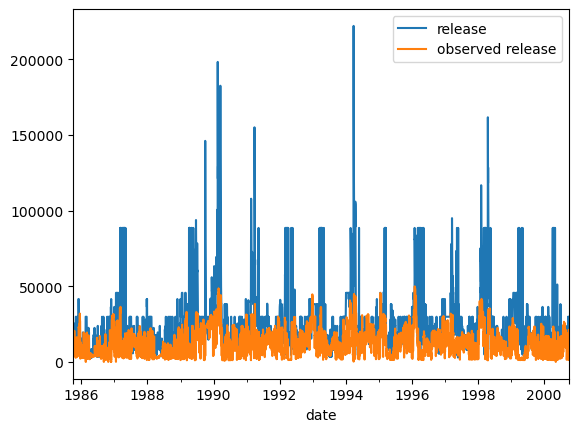

1783
r2 score of release: -0.8918553446911901
pbias of release: 49.74
nrmse of release: 1.143


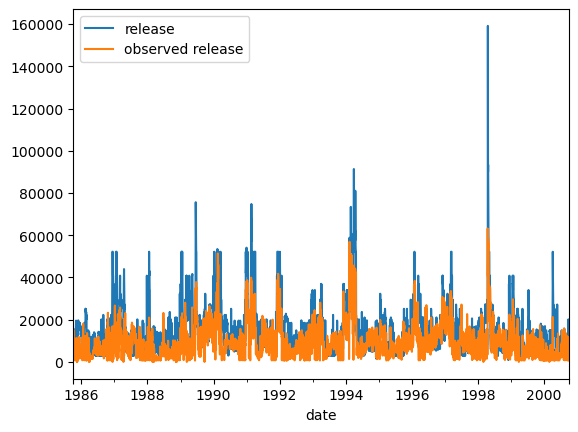

1801
r2 score of release: -4.020553285879962
pbias of release: 33.80
nrmse of release: 1.238


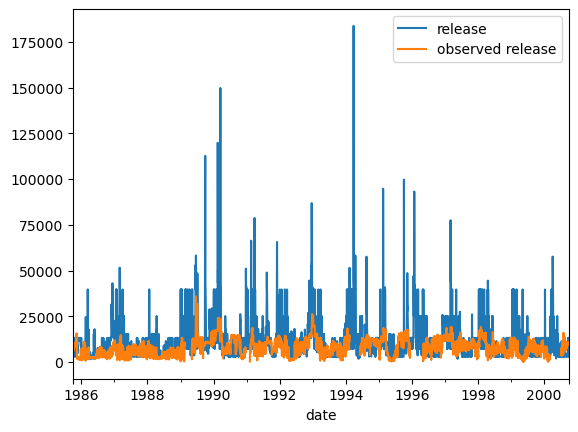

In [5]:
# ---- Check reservoir release against the observed release ---- #

# plot_start_date = start_date
# plot_end_date = end_date
plot_start_date = '1985-10-01'
plot_end_date = '2000-10-01'
# plot_start_date = '2005-10-01'
# plot_end_date = '2018-10-01'

# reservoir metadata
df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx')

# Read observed release
for reservoir_id in reservoir_in_huc4_id:
    print(reservoir_id)

    df_reservoir_ts[f'reservoir_{reservoir_id}_observed_release'] = np.nan
    df_reservoir_ts[f'reservoir_{reservoir_id}_observed_storage_start'] = np.nan
    df_reservoir_ts[f'reservoir_{reservoir_id}_observed_inflow'] = np.nan

    reservoir_smax = df_res_meta.loc[df_res_meta['ID']==reservoir_id, 'Maximum Storage'].values[0]
    df_ts = pd.read_csv(f'{reservoir_data_dir}/data_training/{reservoir_id}.csv')
    df_ts[['Storage', 'NetInflow', 'Release']] = df_ts[['Storage', 'NetInflow', 'Release']] * reservoir_smax
    df_ts['Time'] = pd.to_datetime(df_ts['Time'])
    df_ts.set_index('Time', inplace=True)

    # add observed release to df_reservoir_ts
    df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_release'] = df_ts['Release']
    df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_storage_start'] = df_ts['Storage']
    df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_inflow'] = df_ts['NetInflow']

    # Calculate metrics
    # drop nan
    df_reservoir_ts_dropna = df_reservoir_ts.dropna()
    # 1. r2 score
    r2_release = r2_score(df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'], df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'])

    # 2. percent bias
    pbias_release = (df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'].sum() - df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].sum()) / df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].sum() * 100

    # 3. nRMSE
    nrmse_release = mean_squared_error(df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'], df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'], squared=False) / df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].mean()
    
    print(f'r2 score of release: {r2_release}')
    print(f'pbias of release: {pbias_release:.2f}')
    print(f'nrmse of release: {nrmse_release:.3f}')
    # print(f'r2 score of inflow: {r2_inflow}')
    # print(f'r2 score of storage: {r2_storage}')

    fig, ax = plt.subplots()
    df_reservoir_ts.loc[plot_start_date:plot_end_date, f'reservoir_{reservoir_id}_release'].plot(ax=ax, label='release')
    df_reservoir_ts.loc[plot_start_date:plot_end_date, f'reservoir_{reservoir_id}_observed_release'].plot(ax=ax, label='observed release')
    ax.legend()
    plt.show()

In [243]:
df_reservoir_ts.isna().sum()

reservoir_1151_storage_start                0
reservoir_1151_storage_end                  0
reservoir_1151_inflow                       0
reservoir_1151_release                      0
reservoir_1164_storage_start                0
                                         ... 
reservoir_1237_observed_storage_start       4
reservoir_1237_observed_inflow              4
reservoir_1287_observed_release          2923
reservoir_1287_observed_storage_start    2923
reservoir_1287_observed_inflow           2923
Length: 77, dtype: int64

In [237]:
df_ts.index

DatetimeIndex(['1998-01-19', '1998-01-20', '1998-01-21', '1998-01-22',
               '1998-01-23', '1998-01-24', '1998-01-25', '1998-01-26',
               '1998-01-27', '1998-01-28',
               ...
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22'],
              dtype='datetime64[ns]', name='Time', length=7305, freq=None)